In [1]:
!pip install torchsr

In [17]:
import numpy as np
import pandas as pd
import math
import os

import re
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from torchsr.models import edsr
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision import models
import torch.nn.functional as F


from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random


import warnings
warnings.filterwarnings("ignore")

In [3]:
class CFG:
    epochs = 20
    batch_size = 8
    
    root_dir = '/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash'
    high_res_dir = os.path.join(root_dir, 'high res')
    low_res_dir = os.path.join(root_dir, 'low res')
    df_dir = os.path.join(root_dir, 'image_data.csv')

In [4]:
df = pd.read_csv(CFG.df_dir)
df['low_res'] = df['low_res'].apply(lambda x: os.path.join(CFG.low_res_dir, x))
df['high_res'] = df['high_res'].apply(lambda x: os.path.join(CFG.high_res_dir, x))

df.head()

low_res  \
0  /kaggle/input/image-super-resolution-from-unsp...   
1  /kaggle/input/image-super-resolution-from-unsp...   
2  /kaggle/input/image-super-resolution-from-unsp...   
3  /kaggle/input/image-super-resolution-from-unsp...   
4  /kaggle/input/image-super-resolution-from-unsp...   

                                            high_res  
0  /kaggle/input/image-super-resolution-from-unsp...  
1  /kaggle/input/image-super-resolution-from-unsp...  
2  /kaggle/input/image-super-resolution-from-unsp...  
3  /kaggle/input/image-super-resolution-from-unsp...  
4  /kaggle/input/image-super-resolution-from-unsp...

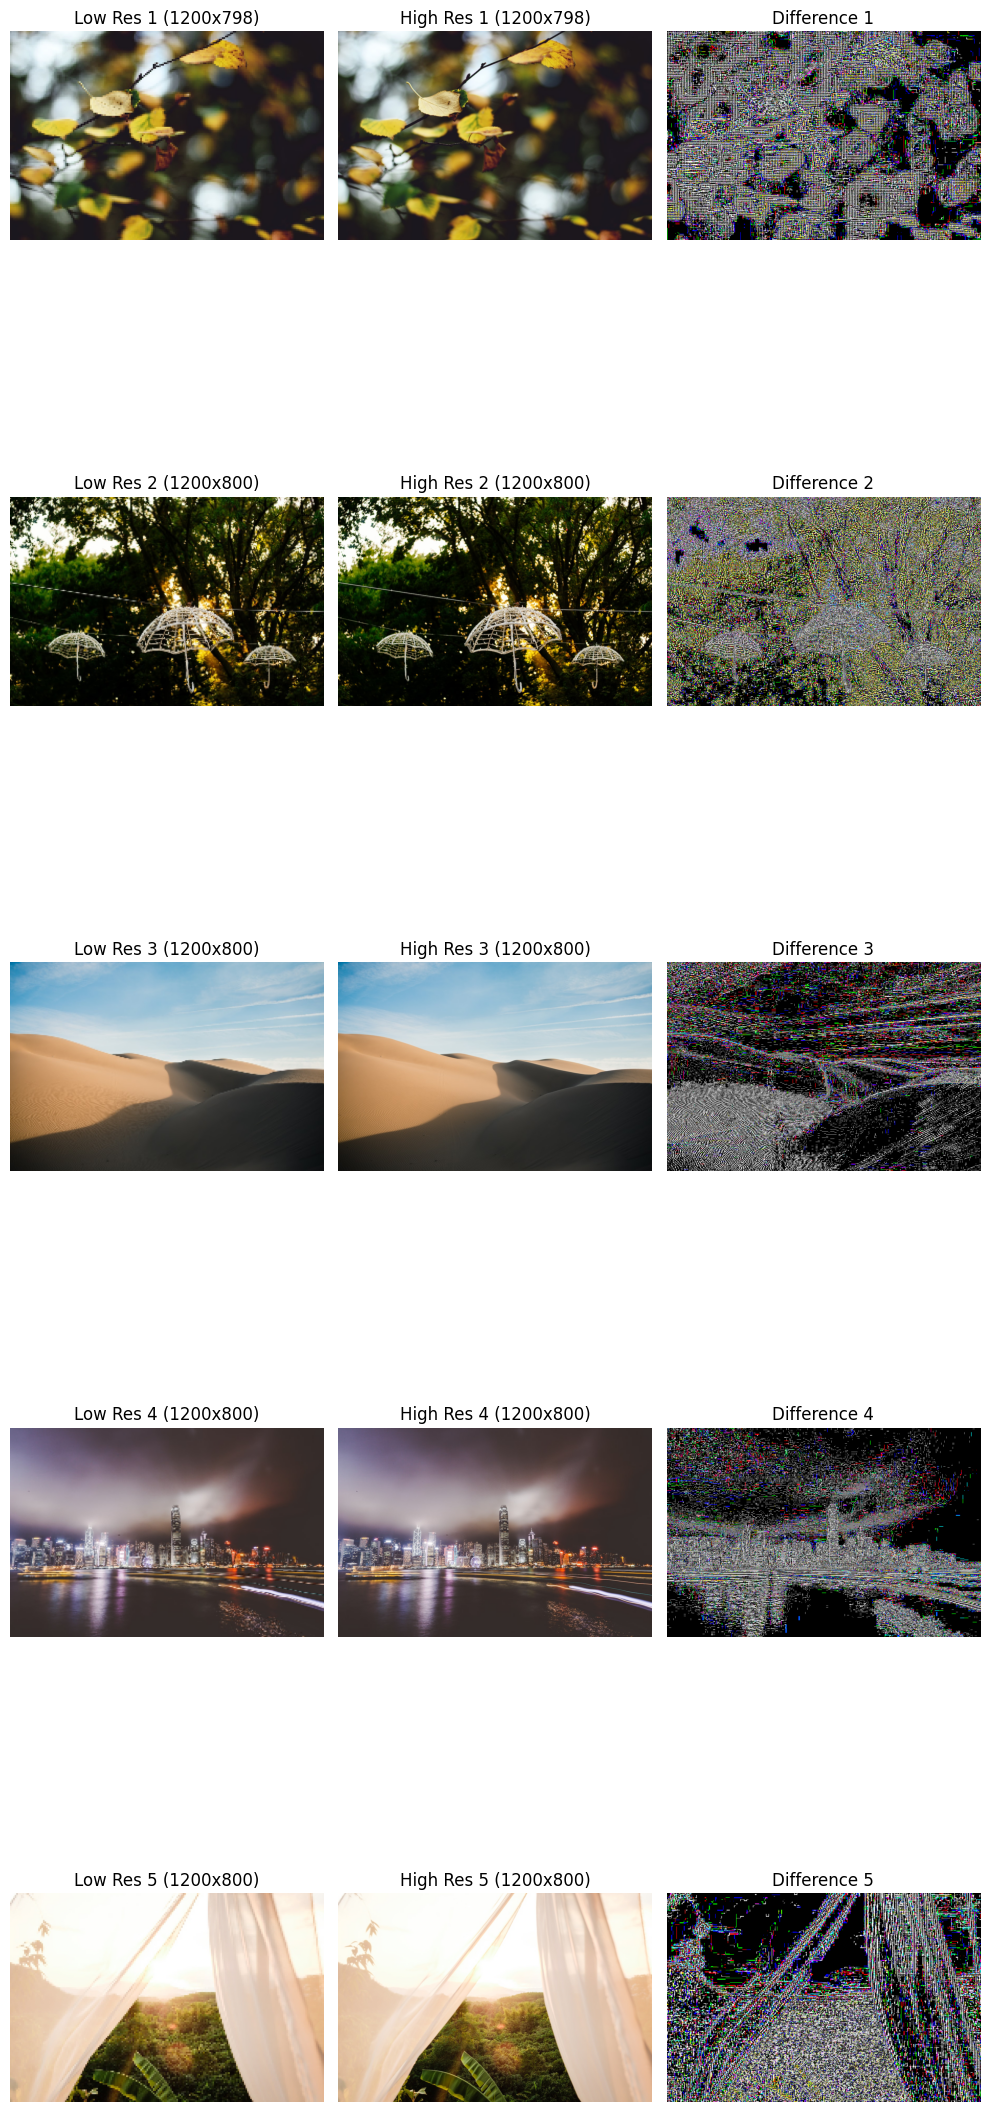

In [5]:
df_random = df.sample(n=5)
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 25))
for i in range(5):
    low_res_img = Image.open(df_random['low_res'].iloc[i])
    high_res_img = Image.open(df_random['high_res'].iloc[i])
    
    low_res_array = np.array(low_res_img)
    high_res_array = np.array(high_res_img.resize(low_res_img.size))  

    diff_array = np.abs(low_res_array - high_res_array)

    axes[i, 0].imshow(low_res_img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Low Res {i+1} ({low_res_img.size[0]}x{low_res_img.size[1]})')

    axes[i, 1].imshow(high_res_img)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'High Res {i+1} ({high_res_img.size[0]}x{high_res_img.size[1]})')

    axes[i, 2].imshow(diff_array, cmap='gray')  
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f'Difference {i+1}')

plt.tight_layout()
plt.show()

In [6]:
class Low2HighResDataset(Dataset):
    def __init__(self, df, low_res_transforms=None, high_res_transforms=None):
        self.df = df
        self.low_res_transforms = low_res_transforms
        self.high_res_transforms = high_res_transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        low_res_img = Image.open(self.df['low_res'].iloc[idx]).convert('RGB')
        high_res_img = Image.open(self.df['high_res'].iloc[idx]).convert('RGB')

        if self.low_res_transforms is not None:
            low_res_img = self.low_res_transforms(low_res_img)
        if self.high_res_transforms is not None:
            high_res_img = self.high_res_transforms(high_res_img)

        return {
                'low_res': low_res_img,
                'high_res': high_res_img
            }

In [7]:
low_res_transforms = v2.Compose([
    v2.Resize(size=(100, 150)),  
    v2.ToTensor()
])
high_res_transforms = v2.Compose([
    v2.Resize(size=(400, 600)), 
    v2.ToTensor()
])

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_dataset = Low2HighResDataset(
    train_df,
    low_res_transforms=low_res_transforms,
    high_res_transforms=high_res_transforms
)
test_dataset = Low2HighResDataset(
    test_df,
    low_res_transforms=low_res_transforms,
    high_res_transforms=high_res_transforms
)
 
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 3009
Testing samples: 753


In [8]:
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out) * x

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)

        return self.sigmoid(out) * x

    class EnhancedResBlock(nn.Module):
    def __init__(self, channels):
        super(EnhancedResBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

        self.channel_attention = ChannelAttention(channels)
        self.spatial_attention = SpatialAttention()

        self.res_scale = 0.1
        
    def forward(self, x):
        res = x
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.channel_attention(out)

        out = self.spatial_attention(out)

        out = out * self.res_scale + res
        
        return out

class ContrastiveResBlock(nn.Module):
    def __init__(self, channels):
        super(ContrastiveResBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

        self.alt_conv = nn.Conv2d(channels, channels, kernel_size=5, padding=2)

        self.fusion = nn.Conv2d(channels * 2, channels, kernel_size=1)

        self.res_scale = 0.1
        
    def forward(self, x):
        res = x

        out1 = self.conv1(x)
        out1 = self.relu(out1)
        out1 = self.conv2(out1)

        out2 = self.alt_conv(x)

        out = torch.cat([out1, out2], dim=1)
        out = self.fusion(out)

        out = out * self.res_scale + res
        
        return out

class Upsampler(nn.Module):
    def __init__(self, channels, scale):
        super(Upsampler, self).__init__()
        
        modules = []
        for _ in range(scale // 2):
            modules.append(nn.Conv2d(channels, channels * 4, kernel_size=3, padding=1))
            modules.append(nn.PixelShuffle(2))
            modules.append(nn.ReLU(inplace=True))
            
            modules.append(nn.Conv2d(channels, channels, kernel_size=3, padding=1))
            modules.append(nn.ReLU(inplace=True))
        
        self.body = nn.Sequential(*modules)
        
    def forward(self, x):
        return self.body(x)

class EnhancedEDSR(nn.Module):/
    def __init__(self, base_edsr_model, num_enhanced_blocks=3):
        super(EnhancedEDSR, self).__init__()
        
        self.head = base_edsr_model.head
        self.body = base_edsr_model.body

        self.enhanced_blocks = nn.ModuleList()
        channels = 256  
        
        for i in range(num_enhanced_blocks):
            if i % 2 == 0:
                self.enhanced_blocks.append(EnhancedResBlock(channels))
            else:
                self.enhanced_blocks.append(ContrastiveResBlock(channels))

        self.upsampler = Upsampler(channels, scale=4)
        
        self.final_conv = nn.Sequential(
            nn.Conv2d(channels, 3, kernel_size=3, padding=1),
            nn.Sigmoid()  
        )

        self.global_fusion = nn.Conv2d(channels * 2, channels, kernel_size=1)
        
    def forward(self, x):
        head = self.head(x)

        body_features = self.body(head)
        
        enhanced_features = body_features
        for block in self.enhanced_blocks:
            enhanced_features = block(enhanced_features)
        
        combined = torch.cat([body_features, enhanced_features], dim=1)
        fused = self.global_fusion(combined)

        fused = fused + head

        upsampled = self.upsampler(fused)

        out = self.final_conv(upsampled)
        
        return out


In [9]:
class CombinedLoss(nn.Module):
    def __init__(self, lambda_l1=0.5):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        self.lambda_l1 = lambda_l1
        
    def forward(self, outputs, targets):
        mse = self.mse_loss(outputs, targets)
        l1 = self.l1_loss(outputs, targets)
        return mse + self.lambda_l1 * l1

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = edsr(scale=4, pretrained=True)  
for param in model.parameters():
        param.requires_grad = False
model = EnhancedEDSR(model, 3).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-4) 
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.2, min_lr=1e-8, verbose=True
)
psnr = torchmetrics.PeakSignalNoiseRatio(data_range=4.0).to(device)


Epoch [1/20], Train Loss: 0.1235, Train PSNR: 21.52, Val Loss: 0.0895, Val PSNR: 22.59
Epoch [2/20], Train Loss: 0.0882, Train PSNR: 22.66, Val Loss: 0.0883, Val PSNR: 22.66
Epoch [3/20], Train Loss: 0.0866, Train PSNR: 22.74, Val Loss: 0.0861, Val PSNR: 22.76
Epoch [4/20], Train Loss: 0.0839, Train PSNR: 22.87, Val Loss: 0.0830, Val PSNR: 22.93
Epoch [5/20], Train Loss: 0.0796, Train PSNR: 23.09, Val Loss: 0.0768, Val PSNR: 23.23
Epoch [6/20], Train Loss: 0.0714, Train PSNR: 23.57, Val Loss: 0.0656, Val PSNR: 23.94
Epoch [7/20], Train Loss: 0.0560, Train PSNR: 24.65, Val Loss: 0.0435, Val PSNR: 25.70
Epoch [8/20], Train Loss: 0.0300, Train PSNR: 27.47, Val Loss: 0.0173, Val PSNR: 29.77
Epoch [9/20], Train Loss: 0.0145, Train PSNR: 30.63, Val Loss: 0.0128, Val PSNR: 31.15
Epoch [10/20], Train Loss: 0.0130, Train PSNR: 31.10, Val Loss: 0.0123, Val PSNR: 31.36
Epoch [11/20], Train Loss: 0.0126, Train PSNR: 31.28, Val Loss: 0.0118, Val PSNR: 31.52
Epoch [12/20], Train Loss: 0.0123, Train 

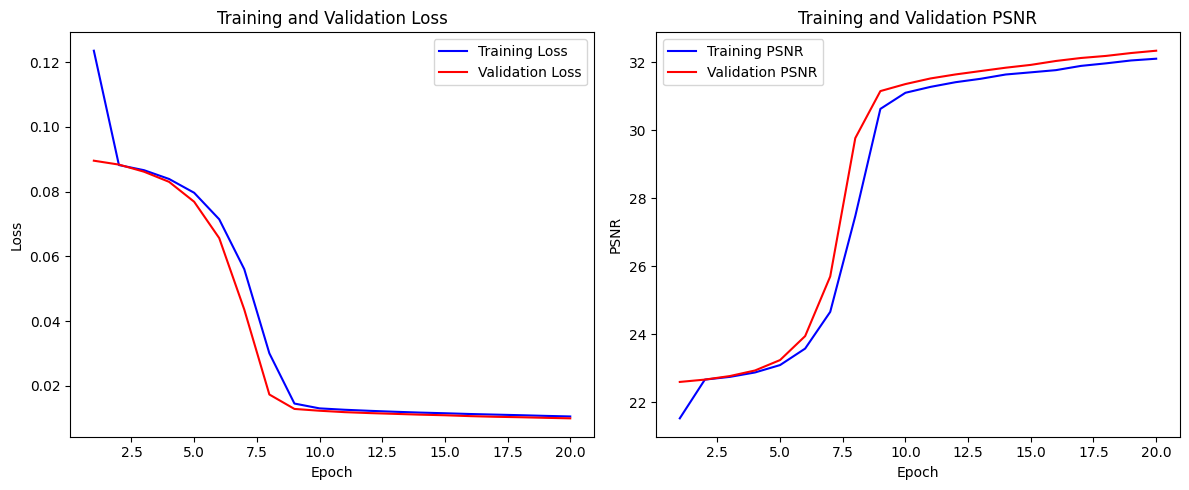

In [14]:
def train(model, optimizer, criterion, psnr, lr_scheduler, device):
    train_losses = []
    train_psnrs = []
    val_losses = []
    val_psnrs = []
    
    for epoch in range(CFG.epochs):
        model.train()
        train_loss = 0
        train_psnr = 0
        
        for batch in train_loader:
            low_res = batch['low_res'].to(device)
            high_res = batch['high_res'].to(device)
            optimizer.zero_grad()
            output = model(low_res)
            loss = criterion(output, high_res)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * low_res.size(0)
            train_psnr += psnr(output, high_res).item() * low_res.size(0)
        
        train_loss /= len(train_dataset)
        train_psnr /= len(train_dataset)
        
        model.eval()
        val_loss = 0
        val_psnr = 0
        
        with torch.no_grad():
            for batch in test_loader:
                low_res = batch['low_res'].to(device)
                high_res = batch['high_res'].to(device)
                output = model(low_res)
                val_loss += criterion(output, high_res).item() * low_res.size(0)
                val_psnr += psnr(output, high_res).item() * low_res.size(0)
        
        val_loss /= len(test_dataset)
        val_psnr /= len(test_dataset)
        
        train_losses.append(train_loss)
        train_psnrs.append(train_psnr)
        val_losses.append(val_loss)
        val_psnrs.append(val_psnr)
        
        print(f"Epoch [{epoch+1}/{CFG.epochs}], Train Loss: {train_loss:.4f}, Train PSNR: {train_psnr:.2f}, Val Loss: {val_loss:.4f}, Val PSNR: {val_psnr:.2f}")
        
        lr_scheduler.step(val_loss)
    
    epochs = range(1, CFG.epochs + 1)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_psnrs, 'b-', label='Training PSNR')
    plt.plot(epochs, val_psnrs, 'r-', label='Validation PSNR')
    plt.title('Training and Validation PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

train(model, optimizer, criterion, psnr, lr_scheduler, device)

In [15]:
model_path = "autoencoder_final.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to autoencoder_final.pth


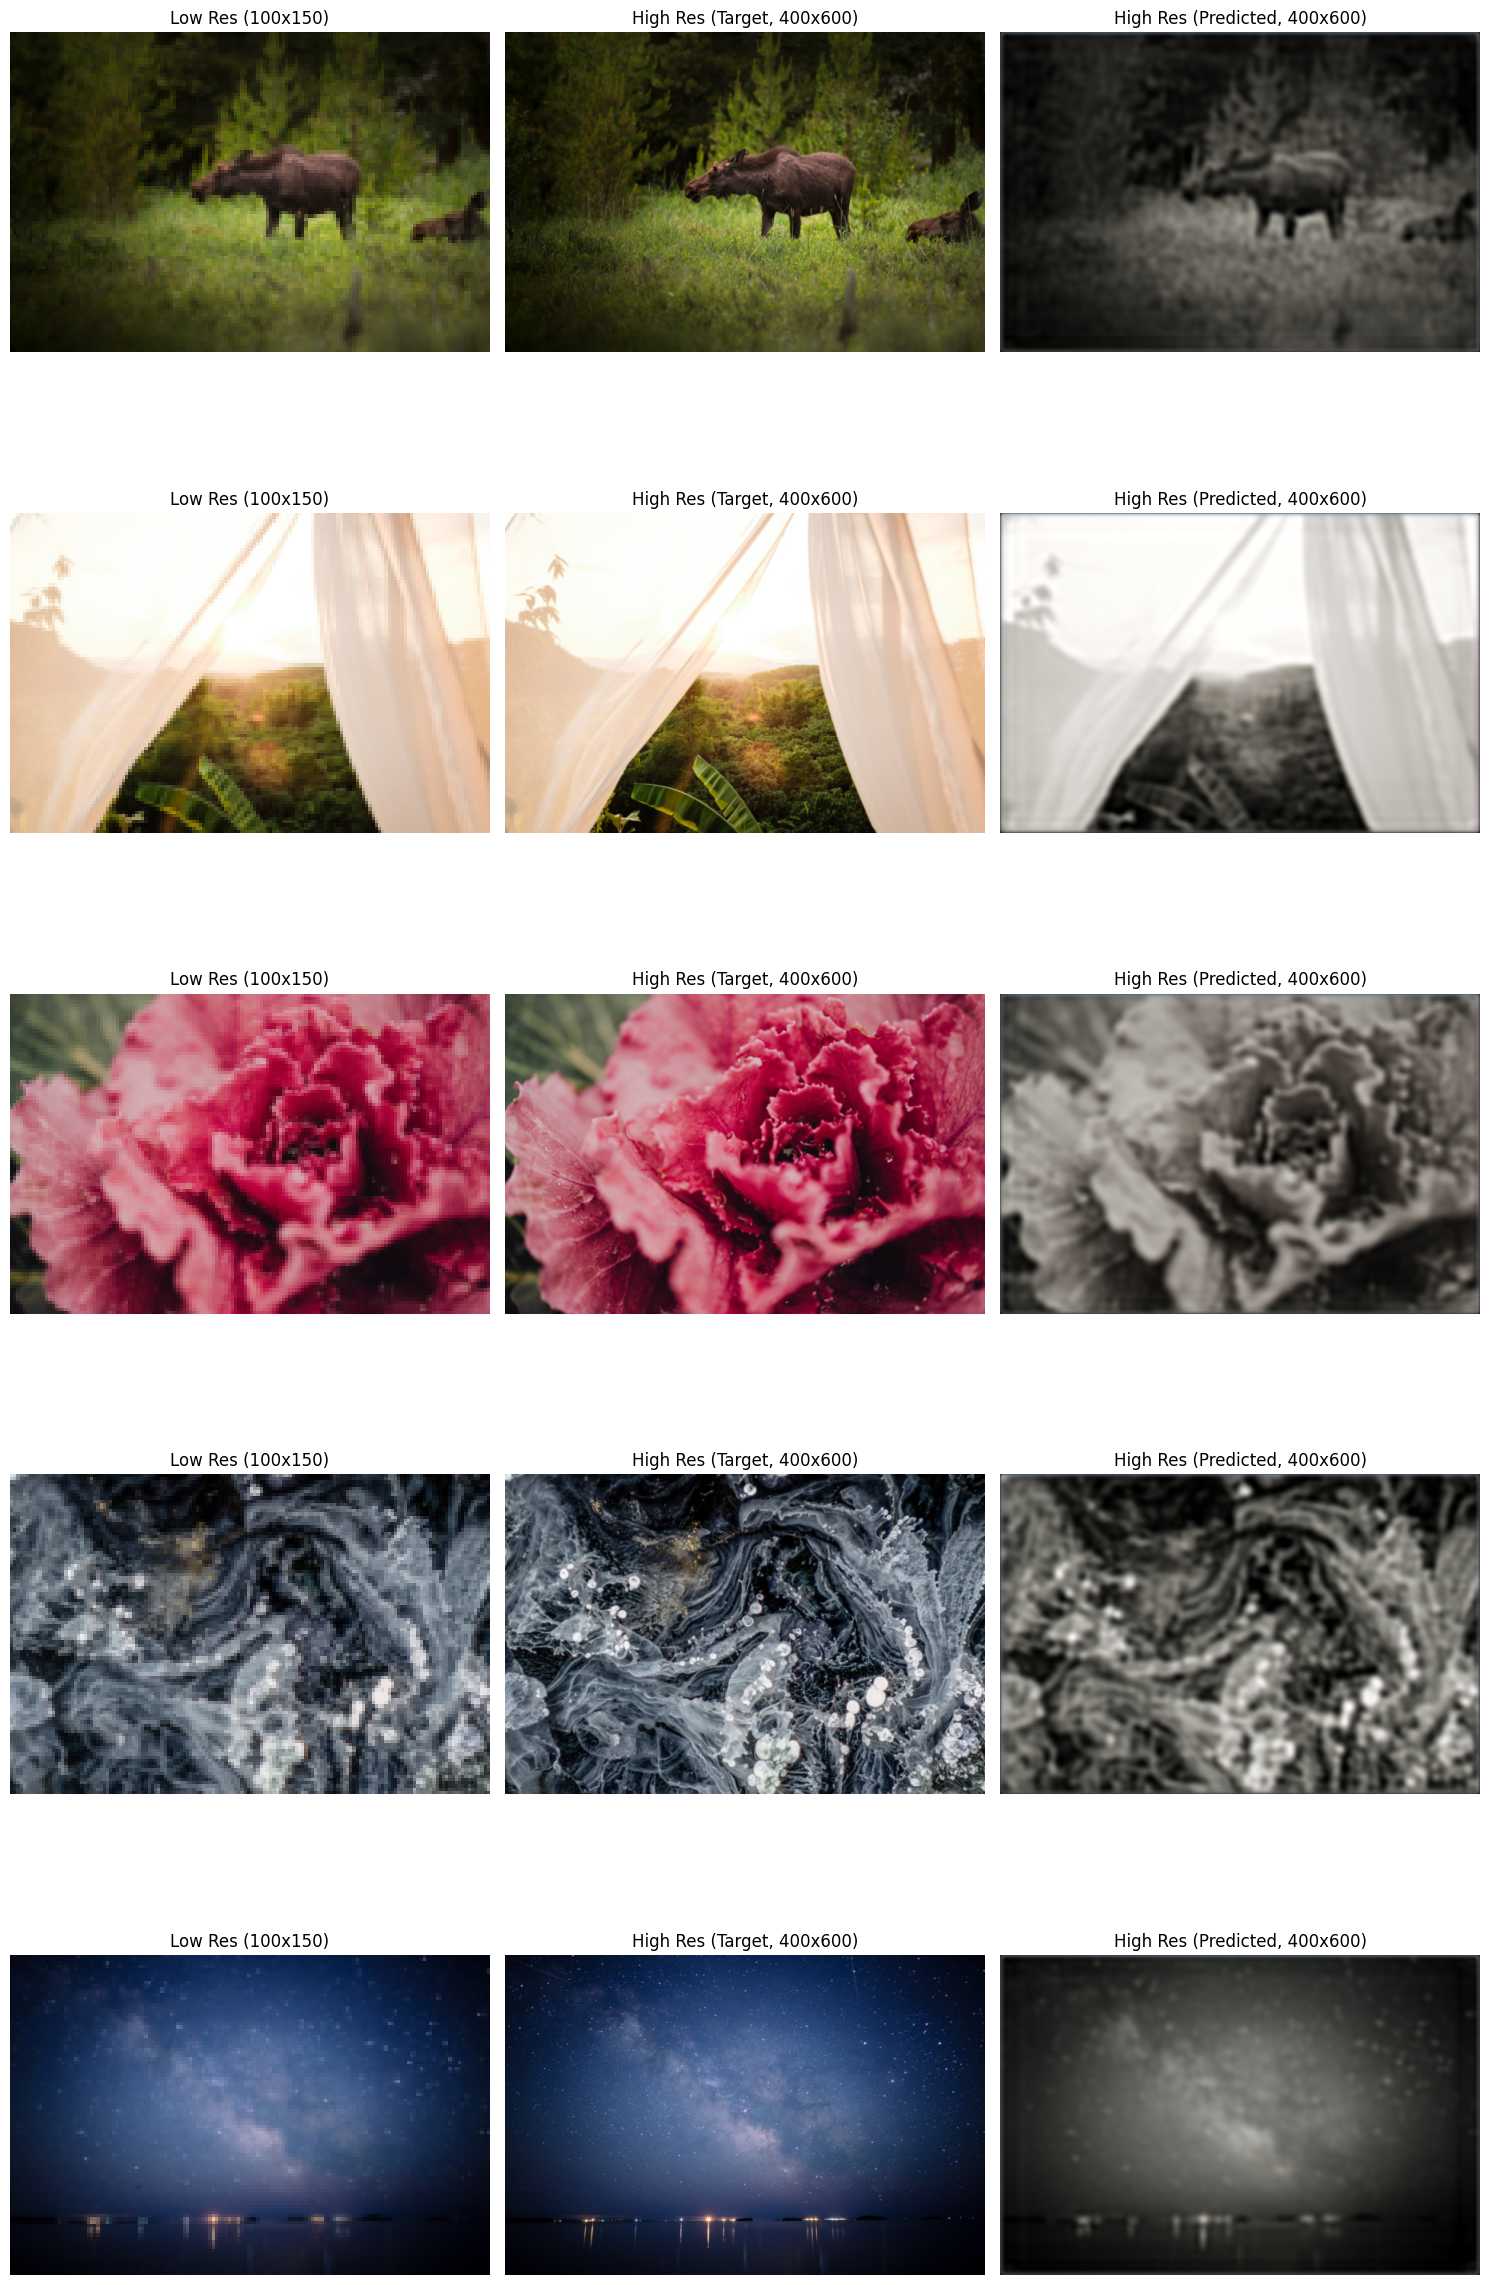

In [21]:
model.eval()
with torch.no_grad():
    all_batches = list(test_loader)

    num_samples = min(5, len(all_batches))
    random_batches = random.sample(all_batches, num_samples)

    batch = random_batches[0]
    low_res = batch['low_res'].to(device)
    high_res = batch['high_res'].to(device)
    output = model(low_res)

    num_images = min(5, low_res.size(0))
    
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    for i in range(num_images):
        low_res_img = low_res[i].cpu().permute(1, 2, 0).numpy()
        high_res_img = high_res[i].cpu().permute(1, 2, 0).numpy()
        pred_img = output[i].cpu().permute(1, 2, 0).numpy()

        low_res_img = low_res_img.clip(0, 1)
        high_res_img = high_res_img.clip(0, 1)
        pred_img = pred_img.clip(0, 1)

        axes[i, 0].imshow(low_res_img)
        axes[i, 0].set_title("Low Res (100x150)")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(high_res_img)
        axes[i, 1].set_title("High Res (Target, 400x600)")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_img)
        axes[i, 2].set_title("High Res (Predicted, 400x600)")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()